In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio


In [18]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')


In [25]:
import pandas as pd
import numpy as np
import glob
import os # Make sure os is imported if you use it in load_borehole_data

# Assuming load_borehole_data is defined as before and dfs is loaded.
# Example:
def load_borehole_data(data_dir='../data'):
    # ... (your existing load_borehole_data function)
    # Get all CSV files in the data directory
    csv_files = glob.glob(os.path.join(data_dir, '*.csv'))
    dataframes = []
    filenames = [] # Store filenames for naming processed dfs
    
    for i, file in enumerate(csv_files):
        df = pd.read_csv(file)
        df['Date/Depth'] = pd.to_datetime(df['Date/Depth'])
        dataframes.append(df)
        filenames.append(os.path.basename(file)) # Store filename
        print(f"Loaded dataset {i+1}: {os.path.basename(file)}")
        
    return dataframes, filenames


import pandas as pd
import numpy as np
import glob
import os

def process_borehole_data():
    
    df_list, df_names = load_borehole_data()
    
    processed_dfs = []

    for i, df_original in enumerate(df_list):
        df = df_original.copy()

        if 'Date/Depth' in df.columns:
            df = df.set_index('Date/Depth')
        
        # Store original column names that are intended as depth columns
        original_depth_col_names = df.columns.tolist()
        
        # Convert to numeric, replace -999, and identify valid depth columns
        # These will be the columns actually used for numeric operations
        valid_numeric_depth_cols_map = {} # Maps float(depth) to original_name
        
        temp_df_for_processing = pd.DataFrame(index=df.index)

        for col_name in original_depth_col_names:
            try:
                # Try to convert column name to float to treat it as a depth
                depth_val_float = float(col_name)
                # Process the column: replace -999, convert to numeric
                processed_col = pd.to_numeric(df[col_name].replace(-999, np.nan), errors='coerce')
                temp_df_for_processing[col_name] = processed_col # Keep original name as column key
                if not processed_col.isna().all(): # Only consider if it has some valid data
                    valid_numeric_depth_cols_map[depth_val_float] = col_name
            except ValueError:
                print(f"Warning: Column '{col_name}' in dfm[{i}] is not a purely numeric depth name and will be ignored for temperature processing.")
        
        if not valid_numeric_depth_cols_map:
            print(f"Error: No valid numeric depth columns found for dfm[{i}] after attempting conversion. Skipping this DataFrame.")
            processed_dfs.append(pd.DataFrame()) # Append an empty DataFrame
            continue

        # These are the names of columns that are valid numeric depths and have data
        actual_depth_cols_to_resample = list(valid_numeric_depth_cols_map.values())
        
        monthly_avg_temps = temp_df_for_processing[actual_depth_cols_to_resample].resample('ME').mean()

        zero_crossing_depths_monthly = []
        
        # Get sorted float depth values *from the columns that are actually in monthly_avg_temps*
        # and their corresponding original names for correct indexing.
        depth_val_float_to_original_name_in_avg = {}
        for col_in_avg in monthly_avg_temps.columns:
            try:
                depth_val_float_to_original_name_in_avg[float(col_in_avg)] = col_in_avg
            except ValueError:
                 # This should not happen if actual_depth_cols_to_resample was correctly formed
                print(f"Warning: Column '{col_in_avg}' in monthly_avg_temps for dfm[{i}] is not numeric. Skipping for zero-crossing.")
                continue
        
        # Sorted float depth values that are present in monthly_avg_temps
        sorted_float_depths_in_avg = sorted(depth_val_float_to_original_name_in_avg.keys())
        
        # Names of columns in monthly_avg_temps, sorted by their numeric depth value
        sorted_col_names_in_avg = [depth_val_float_to_original_name_in_avg[f_val] for f_val in sorted_float_depths_in_avg]
        
        # Re-index monthly_avg_temps by these sorted column names to ensure interpolation order
        monthly_avg_temps_sorted_for_interp = monthly_avg_temps[sorted_col_names_in_avg]

        for month_idx, row_temps in monthly_avg_temps_sorted_for_interp.iterrows():
            current_month_zero_depth = np.nan
            
            valid_indices = ~row_temps.isna()
            temps_for_month = row_temps[valid_indices].values
            # Use sorted_float_depths_in_avg, aligned with the columns of monthly_avg_temps_sorted_for_interp
            depths_for_month_float_array = np.array(sorted_float_depths_in_avg)[valid_indices.values if isinstance(valid_indices, pd.Series) else valid_indices]

            if len(temps_for_month) < 2:
                zero_crossing_depths_monthly.append(current_month_zero_depth)
                continue

            for j in range(len(temps_for_month) - 1):
                temp1, temp2 = temps_for_month[j], temps_for_month[j+1]
                depth1, depth2 = depths_for_month_float_array[j], depths_for_month_float_array[j+1]

                if (temp1 >= 0 and temp2 < 0) or (temp1 <= 0 and temp2 > 0):
                    if temp2 - temp1 == 0:
                        current_month_zero_depth = depth1 if temp1 == 0 else np.nan
                    else:
                        current_month_zero_depth = depth1 - temp1 * (depth2 - depth1) / (temp2 - temp1)
                    
                    if not (current_month_zero_depth >= 0):
                        current_month_zero_depth = np.nan
                    break
            
            zero_crossing_depths_monthly.append(current_month_zero_depth)

        # monthly_avg_temps still has its original (but valid numeric) column names
        monthly_avg_temps['Zero_Crossing_Depth'] = zero_crossing_depths_monthly
        
        dfm = monthly_avg_temps.reset_index()
        dfm.rename(columns={'Date/Depth': 'Month_DateTime'}, inplace=True)
        dfm['Month'] = dfm['Month_DateTime'].dt.strftime('%Y-%m')
        
        # Columns present in monthly_avg_temps (excluding the newly added 'Zero_Crossing_Depth')
        # These are the actual_depth_cols_to_resample
        final_depth_cols_in_dfm = [col for col in monthly_avg_temps.columns if col != 'Zero_Crossing_Depth']
        
        # Ensure the order of depth columns is based on their numeric value for final output
        # We use the `sorted_col_names_in_avg` which are the original names, sorted numerically
        # Filter these to ensure they are in final_depth_cols_in_dfm (they should be)
        ordered_depth_cols_for_output = [name for name in sorted_col_names_in_avg if name in final_depth_cols_in_dfm]

        final_cols_order = ['Month'] + ordered_depth_cols_for_output + ['Zero_Crossing_Depth']
        
        # Handle case where a column in final_cols_order might have been all NaNs and dropped
        # by resample().mean() if it had no valid numeric data initially.
        # We should only select columns that actually exist in dfm at this point.
        existing_cols_for_final_dfm = [col for col in final_cols_order if col in dfm.columns]
        dfm = dfm[existing_cols_for_final_dfm]
        
        processed_dfs.append(dfm)
        print(f"Processed dfm[{i}] with {len(dfm)} months of data. Columns: {dfm.columns.tolist()}")

    return processed_dfs

# --- Example of how to load and run ---
# def load_borehole_data(data_dir='../data'):
#     # ... (your existing load_borehole_data function) ...
#     csv_files = glob.glob(os.path.join(data_dir, '*.csv'))
#     dataframes = []
#     for i, file in enumerate(csv_files):
#         df = pd.read_csv(file)
#         df['Date/Depth'] = pd.to_datetime(df['Date/Depth'])
#         dataframes.append(df)
#         print(f"Loaded dataset {i+1}: {os.path.basename(file)}")
#     return dataframes

# dfs = load_borehole_data() 
# dfm_list = process_borehole_data(dfs)

# if dfm_list:
#     print("\nExample: First 5 rows of the first processed DataFrame (dfm_list[0]):")
#     print(dfm_list[0].head())


# Assuming 'dfs' is your list of initially loaded DataFrames
# And 'df_names' is a list of corresponding original filenames (optional, for naming)

dfm_list = process_borehole_data()

# You can then access each processed DataFrame like:
# dfm_list[0].head()
# dfm_list[1].head()
# etc.

# To assign them to dfm0, dfm1, etc. in the global scope (generally not recommended for many dfs):
# for i, df_processed in enumerate(dfm_list):
#     globals()[f'dfm{i}'] = df_processed

# print("\nExample: First 5 rows of dfm0:")
# if 'dfm0' in globals():
#     print(dfm0.head())
# else:
#     if dfm_list:
#         print(dfm_list[0].head())
#     else:
#         print("No dataframes were processed.")


Loaded dataset 1: Borehole_63-Endalen_PYRN-Dataset_1494-Continuous-6_hours-Ground_Temperature-Thermistor_Automated.timeserie.csv
Loaded dataset 2: Borehole_62-Breinosa__E-2009_-Dataset_1497-Continuous-Hourly-Ground_Temperature-Thermistor_Automated.timeserie.csv
Loaded dataset 3: Borehole_57-Kapp_Linne_1-Dataset_29-Continuous-6_hours-Ground_Temperature-Thermistor_Automated.timeserie.csv
Loaded dataset 4: Borehole_98-Kapp_Linne_2-Dataset_1492-Continuous-6_hours-Ground_Temperature-Thermistor_Automated.timeserie.csv
Loaded dataset 5: Borehole_1192-Bayelva__Ny__lesund_-Dataset_1972-Average-Hourly-Ground_Temperature-Thermistor_Automated.timeserie.csv
Processed dfm[0] with 146 months of data. Columns: ['Month', '0', '0.25', '0.5', '0.75', '1', '1.5', '2', '2.5', '3', '4', '5', '6', '7', '8', '9', '10', '12', '15', '19', 'Zero_Crossing_Depth']
Processed dfm[1] with 78 months of data. Columns: ['Month', '0', '0.25', '0.5', '1', '2', '3', '4', '5', '7', '10', 'Zero_Crossing_Depth']
Processed dfm

In [28]:
dfm_list[4]

,Month,-0.5,0,0.5,1,1.5,2.5,3.5,5.5,7.5,9,Zero_Crossing_Depth
0,2009-08,6.443012,5.383540,3.882453,2.413385,-0.225093,-2.184596,-2.776025,-2.895155,-2.870186,-2.859193,1.457344
1,2009-09,1.613750,1.160347,1.313069,0.980639,-0.213861,-1.931736,-2.599111,-2.870750,-2.871583,-2.868000,1.410481
2,2009-10,-5.618318,-4.617147,-1.796083,-0.442221,-0.343890,-1.698439,-2.438264,-2.827362,-2.870323,-2.869273,NaN
3,2009-11,-5.066375,-5.310569,-4.196306,-2.403681,-1.028819,-1.607917,-2.324250,-2.775833,-2.855083,-2.850250,NaN
4,2009-12,-7.267957,-7.426290,-5.996142,-4.108253,-2.412957,-1.804879,-2.253468,-2.718481,-2.814032,-2.818629,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
144,2021-08,5.871062,5.853280,5.166452,3.521048,0.521532,-2.090954,-2.851788,-2.930175,-2.932823,-2.872419,1.699631
145,2021-09,3.034347,2.767389,2.310333,1.849097,0.536222,-1.594750,-2.520472,-2.885917,-2.932139,-2.879167,1.751633
146,2021-10,-5.636142,-5.341277,-1.443750,-0.027016,-0.020323,-1.354220,-2.302796,-2.826452,-2.924772,-2.880726,NaN
147,2021-11,-12.565000,-12.209292,-7.259222,-3.712639,-1.065042,-1.267167,-2.150194,-2.785917,-2.882333,-2.880750,NaN


In [29]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go # Import graph_objects for adding shapes

def create_animated_temperature_profile_plotly_with_zero_line(dfm, df_name="Dataset"):
    """
    Create an animated monthly temperature profile using Plotly Express,
    including a horizontal line for the zero-crossing depth.

    Parameters:
    dfm (pd.DataFrame): Input processed DataFrame. Expected columns:
                        - 'Month' (YYYY-MM string)
                        - Depth columns (e.g., '0', '0.25', '1.0') with monthly avg temps.
                        - 'Zero_Crossing_Depth' (float, NaN if no crossing).
    df_name (str): Name of the dataset for the plot title.

    Returns:
    plotly.graph_objects.Figure: The animated Plotly figure, or None if data is insufficient.
    """
    
    if dfm.empty:
        print(f"Input DataFrame for {df_name} is empty. Cannot create animation.")
        return None

    # 1. Identify depth columns (excluding 'Month' and 'Zero_Crossing_Depth')
    # Ensure we handle cases where depth columns might be numbers or strings of numbers
    depth_cols_in_dfm = []
    for col in dfm.columns:
        if col not in ['Month', 'Month_DateTime', 'Zero_Crossing_Depth']: # Exclude non-depth columns
            try:
                float(col) # Check if column name can be interpreted as a depth
                depth_cols_in_dfm.append(col)
            except ValueError:
                print(f"Warning: Column '{col}' in {df_name} is not a numeric depth and will be ignored for temperature profiles.")
    
    if not depth_cols_in_dfm:
        print(f"No valid depth columns found in {df_name} for plotting.")
        return None

    # 2. Melt DataFrame to long format for temperature profiles
    df_long = pd.melt(dfm, 
                      id_vars=['Month', 'Zero_Crossing_Depth'], # Keep ZCD for later
                      value_vars=depth_cols_in_dfm, 
                      var_name='Depth_Str', 
                      value_name='Temperature')
    
    # 3. Convert data types
    df_long['Depth'] = pd.to_numeric(df_long['Depth_Str'], errors='coerce')
    df_long['Temperature'] = pd.to_numeric(df_long['Temperature'], errors='coerce')
    
    # Drop rows with NaN temperatures or depths as they can't be plotted for the profile
    df_long.dropna(subset=['Temperature', 'Depth'], inplace=True)
    
    # Sort values for correct line plotting within each frame
    df_long.sort_values(by=['Month', 'Depth'], inplace=True)

    if df_long.empty:
        print(f"No data available to plot for temperature profiles in {df_name} after processing.")
        return None

    # 4. Determine overall temperature and depth ranges for consistent axes
    min_temp_overall = df_long['Temperature'].min()
    max_temp_overall = df_long['Temperature'].max()
    temp_buffer = (max_temp_overall - min_temp_overall) * 0.05 if (max_temp_overall - min_temp_overall) > 0 else 1
    temp_range = [min_temp_overall - temp_buffer, max_temp_overall + temp_buffer]
    
    max_plot_depth = df_long['Depth'].max() # Max physical depth for plotting
    # Invert depth for y-axis display
    # Ensure y_axis range accommodates all depths and zero-crossing lines
    
    # Consider Zero_Crossing_Depth for y_range if it's deeper than max sensor depth
    # (though it shouldn't typically be, this is a safeguard)
    # We plot Zero_Crossing_Depth also inverted.
    all_depths_for_range = list(df_long['Depth'].values)
    if 'Zero_Crossing_Depth' in dfm.columns:
         all_depths_for_range.extend(dfm['Zero_Crossing_Depth'].dropna().values)
    
    if not all_depths_for_range: # Should not happen if df_long is not empty
        y_min_plot = -10 
        y_max_plot = 1
    else:
        max_overall_depth_for_range = max(all_depths_for_range) if all_depths_for_range else 10
        y_min_plot = - (max_overall_depth_for_range + (max_overall_depth_for_range * 0.1 if max_overall_depth_for_range > 0 else 1))
        y_max_plot = (max_overall_depth_for_range * 0.1 if max_overall_depth_for_range > 0 else 1)
        
    depth_range_inverted = [y_min_plot, y_max_plot]


    # 5. Create animated plot using Plotly Express for the temperature profiles
    fig = px.line(df_long,
                  x='Temperature',
                  y=df_long['Depth'] * -1, # Invert depth
                  animation_frame='Month', # Use the 'Month' (YYYY-MM string) column
                  labels={'Temperature': 'Temperature (°C)', 'y': 'Depth (m)'},
                  title=f'Animated Monthly Temperature Profiles: {df_name}',
                  range_x=temp_range,
                  range_y=depth_range_inverted
                 )

    # 6. Add horizontal lines for Zero_Crossing_Depth to each frame
    # Plotly Express animation_frame handles data grouping. To add shapes per frame,
    # we need to iterate through the frames after the figure is created.
    
    # Ensure frames are generated
    fig.layout['sliders'][0]['currentvalue']['prefix'] = 'Month: ' # Optional: customize slider prefix
    
    # We need to access the Zero_Crossing_Depth from the original dfm for each month (frame)
    # Create a dictionary for quick lookup: Month -> Zero_Crossing_Depth
    zcd_map = pd.Series(dfm['Zero_Crossing_Depth'].values, index=dfm['Month']).to_dict()

    new_frames = []
    for frame in fig.frames:
        month_frame_name = frame.name # This should be the 'Month' (YYYY-MM string)
        
        # Start with existing frame data (the temperature profile line)
        frame_data = list(frame.data)
        frame_layout_shapes = list(frame.layout.shapes) if frame.layout and frame.layout.shapes else []

        # Get the Zero_Crossing_Depth for this month
        zcd_value = zcd_map.get(month_frame_name, np.nan)

        if pd.notna(zcd_value) and zcd_value >= 0:
            # Add a horizontal line for the zero crossing depth
            # The y-value also needs to be inverted
            zero_crossing_line_shape = go.layout.Shape(
                type="line",
                x0=temp_range[0], y0=-zcd_value, # Inverted depth
                x1=temp_range[1], y1=-zcd_value, # Inverted depth
                line=dict(color="blue", width=2, dash="dash"),
                name=f"ZCD: {-zcd_value:.2f}m" # Name for potential hover (though shapes don't have direct hover)
            )
            frame_layout_shapes.append(zero_crossing_line_shape)
        
        # Update the frame with the new shape(s)
        # For shapes, they are typically added to the layout of each frame
        frame.layout.shapes = tuple(frame_layout_shapes)
        new_frames.append(go.Frame(data=frame.data, layout=frame.layout, name=frame.name))

    fig.frames = tuple(new_frames)


    # Add shape for the first frame as well (initial view)
    initial_month = df_long['Month'].unique()[0]
    initial_zcd = zcd_map.get(initial_month, np.nan)
    initial_shapes = []
    if pd.notna(initial_zcd) and initial_zcd >= 0:
        initial_shapes.append(go.layout.Shape(
            type="line",
            x0=temp_range[0], y0=-initial_zcd,
            x1=temp_range[1], y1=-initial_zcd,
            line=dict(color="blue", width=2, dash="dash")
        ))
    fig.update_layout(shapes=initial_shapes)


    # Update layout for better animation control and appearance
    fig.update_layout(
        xaxis_title='Temperature (°C)',
        yaxis_title='Depth (m)',
        # Uniform axes for all frames
        xaxis_range=temp_range,
        yaxis_range=depth_range_inverted,
    )
    fig.update_yaxes(autorange=False) 
    fig.update_xaxes(autorange=False)

    # Adjust animation speed
    if fig.layout.updatemenus and len(fig.layout.updatemenus) > 0 and \
       fig.layout.updatemenus[0].buttons and len(fig.layout.updatemenus[0].buttons) > 0:
        fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 500  # ms per frame
        fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 100 # ms for transition

    return fig


In [42]:
# Assuming dfm_list is already created from the previous step
# and df_names was also created by your load_borehole_data function

if len(dfm_list) > 4:
    # Try to get a more descriptive name if df_names exists and has corresponding entry
    dataset_name = f"Dataset {4+1}" # Default name
    # if 'df_names' in globals() and len(df_names) > 4:
    #     dataset_name = df_names[4].split('.')[0] # Example: use filename without extension

    animated_fig_with_line = create_animated_temperature_profile_plotly_with_zero_line(dfm_list[3], df_name=dataset_name)
    
    if animated_fig_with_line:
        animated_fig_with_line.show()
else:
    print("dfm_list does not contain enough processed dataframes (index 4 is out of bounds).")


In [46]:

create_animated_temperature_profile_plotly_with_zero_line(dfm_list[0], 'file0')




In [47]:
create_animated_temperature_profile_plotly_with_zero_line(dfm_list[1], 'file1')


In [48]:
create_animated_temperature_profile_plotly_with_zero_line(dfm_list[2], 'file2')


In [49]:
create_animated_temperature_profile_plotly_with_zero_line(dfm_list[3], 'file3')


In [50]:
create_animated_temperature_profile_plotly_with_zero_line(dfm_list[4], 'file4')

In [51]:
import pandas as pd
import numpy as np
import plotly.express as px

def plot_temp_at_lowest_depth(dfm, df_name="Dataset"):
    """
    Plots the monthly average temperature against month for the lowest depth
    in the given processed DataFrame.

    Parameters:
    dfm (pd.DataFrame): A processed DataFrame. Expected columns:
                        - 'Month' (YYYY-MM string or datetime)
                        - Depth columns (e.g., '0', '0.25', '1.0', '-0.5') 
                          containing monthly average temperature values.
                        - Optionally 'Zero_Crossing_Depth' (not used in this specific plot).
    df_name (str): Name of the dataset for the plot title.

    Returns:
    plotly.graph_objects.Figure: The Plotly line chart, or None if data is insufficient.
    """

    if dfm.empty:
        print(f"DataFrame for {df_name} is empty. Cannot create plot.")
        return None

    if 'Month' not in dfm.columns:
        print(f"DataFrame for {df_name} is missing the 'Month' column. Cannot create plot.")
        return None
        
    plot_df = dfm.copy()

    # 1. Identify depth columns and find the lowest (numerically largest) depth
    depth_col_candidates = {} # Store as float_depth: original_col_name
    for col in plot_df.columns:
        if col.lower() not in ['month', 'month_datetime', 'zero_crossing_depth']:
            try:
                depth_value = float(col)
                depth_col_candidates[depth_value] = col
            except ValueError:
                # Column name is not a simple number, ignore for depth finding
                pass
    
    if not depth_col_candidates:
        print(f"No valid numeric depth columns found in {df_name} to determine lowest depth.")
        return None

    # Determine the lowest depth (numerically largest value)
    lowest_depth_numeric = max(depth_col_candidates.keys())
    lowest_depth_col_name = depth_col_candidates[lowest_depth_numeric]
    
    print(f"Identified lowest depth for {df_name}: {lowest_depth_col_name} m")

    # 2. Prepare data for plotting
    # Select 'Month' and the temperature data for the lowest depth
    if lowest_depth_col_name not in plot_df.columns:
        print(f"Lowest depth column '{lowest_depth_col_name}' not found in DataFrame {df_name}. This should not happen.")
        return None
        
    temp_at_lowest_depth_df = plot_df[['Month', lowest_depth_col_name]].copy()
    temp_at_lowest_depth_df.rename(columns={lowest_depth_col_name: 'Temperature'}, inplace=True)

    # Ensure 'Temperature' is numeric and handle any remaining NaNs from a previous step (e.g. if a month had all NaNs for this depth)
    temp_at_lowest_depth_df['Temperature'] = pd.to_numeric(temp_at_lowest_depth_df['Temperature'], errors='coerce')
    temp_at_lowest_depth_df.dropna(subset=['Temperature'], inplace=True)

    if temp_at_lowest_depth_df.empty:
        print(f"No valid temperature data at the lowest depth ({lowest_depth_col_name}m) for {df_name}.")
        return None
        
    # Convert 'Month' to datetime for proper sorting and time-series plotting, if it's not already
    # Assuming 'Month' is like 'YYYY-MM' string. If it's datetime, this is fine.
    try:
        temp_at_lowest_depth_df['Month_dt'] = pd.to_datetime(temp_at_lowest_depth_df['Month'], format='%Y-%m')
        temp_at_lowest_depth_df.sort_values('Month_dt', inplace=True)
    except ValueError:
         # If 'Month' is already datetime or another parsable format:
        try:
            temp_at_lowest_depth_df['Month_dt'] = pd.to_datetime(temp_at_lowest_depth_df['Month'])
            temp_at_lowest_depth_df.sort_values('Month_dt', inplace=True)
        except Exception as e:
            print(f"Could not parse 'Month' column for sorting: {e}. Plotting with string-based month order.")
            # If it fails, Plotly will try to sort based on string, which usually works for YYYY-MM
            temp_at_lowest_depth_df['Month_dt'] = temp_at_lowest_depth_df['Month']


    # 3. Create the line plot
    fig = px.line(temp_at_lowest_depth_df,
                  x='Month_dt',  # Use the datetime version for the x-axis
                  y='Temperature',
                  labels={'Month_dt': 'Month', 'Temperature': f'Temperature at {lowest_depth_col_name}m (°C)'},
                  title=f'Monthly Temperature at Lowest Depth ({lowest_depth_col_name}m) - {df_name}',
                  markers=True) # Add markers to see individual monthly points

    fig.update_layout(
        xaxis_title='Month',
        yaxis_title=f'Temperature at {lowest_depth_col_name}m (°C)'
    )

    return fig


In [33]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

def plot_yearly_max_min_zero_crossing_depth(dfm, df_name="Dataset"):
    """
    Plots the maximum and minimum Zero_Crossing_Depth for each year.

    Parameters:
    dfm (pd.DataFrame): A processed DataFrame from the dfm_list.
                        Expected columns: 'Month' (YYYY-MM string), 'Zero_Crossing_Depth'.
    df_name (str): Name of the dataset for the plot title.

    Returns:
    plotly.graph_objects.Figure: The Plotly figure, or None if data is insufficient.
    """

    if dfm.empty or 'Month' not in dfm.columns or 'Zero_Crossing_Depth' not in dfm.columns:
        print(f"DataFrame for {df_name} is empty or missing required columns ('Month', 'Zero_Crossing_Depth'). Cannot create plot.")
        return None

    # Make a copy to avoid modifying the original DataFrame
    plot_df = dfm.copy()

    # 1. Convert 'Month' (YYYY-MM string) to datetime objects to extract the year
    #    If 'Month' is already datetime, this step might be adjusted or skipped.
    #    Assuming 'Month' is like '2008-09'.
    try:
        plot_df['Year'] = pd.to_datetime(plot_df['Month'], format='%Y-%m').dt.year
    except ValueError:
        print(f"Could not parse 'Month' column in {df_name} to extract year. Ensure it's in YYYY-MM format.")
        # Attempt to parse if it's already datetime-like (e.g., from monthly_avg_temps.reset_index())
        if 'Month_DateTime' in plot_df.columns:
             plot_df['Year'] = pd.to_datetime(plot_df['Month_DateTime']).dt.year
        else: # If 'Month' column is not in YYYY-MM and no Month_DateTime, this will fail or give wrong results
            print(f"Error: 'Month' column format issue in {df_name}. Cannot extract year.")
            return None


    # 2. Filter out NaN values in 'Zero_Crossing_Depth' before aggregation
    plot_df_valid_zcd = plot_df.dropna(subset=['Zero_Crossing_Depth'])

    if plot_df_valid_zcd.empty:
        print(f"No valid Zero_Crossing_Depth data to plot for {df_name}.")
        return None

    # 3. Group by 'Year' and calculate max and min 'Zero_Crossing_Depth'
    yearly_zcd_stats = plot_df_valid_zcd.groupby('Year')['Zero_Crossing_Depth'].agg(['max', 'min']).reset_index()
    yearly_zcd_stats.rename(columns={'max': 'Max_ZCD', 'min': 'Min_ZCD'}, inplace=True)
    
    if yearly_zcd_stats.empty:
        print(f"No yearly ZCD statistics could be computed for {df_name}.")
        return None

    # 4. Create the plot
    fig = go.Figure()

    # Add Max Zero Crossing Depth trace
    fig.add_trace(go.Scatter(
        x=yearly_zcd_stats['Year'],
        y=yearly_zcd_stats['Max_ZCD'],
        mode='lines+markers',
        name='Max Zero-Crossing Depth',
        line=dict(color='red'),
        marker=dict(symbol='circle')
    ))

    # Add Min Zero Crossing Depth trace
    fig.add_trace(go.Scatter(
        x=yearly_zcd_stats['Year'],
        y=yearly_zcd_stats['Min_ZCD'],
        mode='lines+markers',
        name='Min Zero-Crossing Depth',
        line=dict(color='blue'),
        marker=dict(symbol='x')
    ))

    # Update layout
    fig.update_layout(
        title=f'Yearly Max and Min Zero-Crossing Depth: {df_name}',
        xaxis_title='Year',
        yaxis_title='Zero-Crossing Depth (m)',
        legend_title='Statistic',
        hovermode="x unified"
    )
    
    # Ensure years are treated as categories if there are few, or allow Plotly to handle if many
    if len(yearly_zcd_stats['Year'].unique()) < 15: # Arbitrary threshold
        fig.update_xaxes(type='category')


    return fig


In [67]:
plot_temp_at_lowest_depth(dfm_list[2], 'file')

Identified lowest depth for file: 29 m


In [61]:
# Assuming dfm_list is already created from your previous processing step
# and df_names was also created by your load_borehole_data function (optional)

if len(dfm_list) > 4:
    # Try to get a more descriptive name if df_names exists
    dataset_name = f"Dataset {4+1}" # Default name
    # if 'df_names' in globals() and isinstance(df_names, list) and len(df_names) > 4:
    #     dataset_name = df_names[4].split('.')[0] # Example

    zcd_yearly_plot = plot_yearly_max_min_zero_crossing_depth(dfm_list[0], df_name=dataset_name)
    
    if zcd_yearly_plot:
        zcd_yearly_plot.show()
else:
    print("dfm_list does not contain enough processed dataframes (index 4 is out of bounds).")

# To plot for all processed dataframes:
# for i, dfm_item in enumerate(dfm_list):
#     dataset_name_loop = f"Dataset {i+1}"
#     if 'df_names' in globals() and isinstance(df_names, list) and len(df_names) > i:
#          dataset_name_loop = df_names[i].split('.')[0]
    
#     print(f"\nPlotting for {dataset_name_loop}:")
#     fig_loop = plot_yearly_max_min_zero_crossing_depth(dfm_item, df_name=dataset_name_loop)
#     if fig_loop:
#         fig_loop.show()


In [58]:
dfm_list[4]

,Month,-0.5,0,0.5,1,1.5,2.5,3.5,5.5,7.5,9,Zero_Crossing_Depth
0,2009-08,6.443012,5.383540,3.882453,2.413385,-0.225093,-2.184596,-2.776025,-2.895155,-2.870186,-2.859193,1.457344
1,2009-09,1.613750,1.160347,1.313069,0.980639,-0.213861,-1.931736,-2.599111,-2.870750,-2.871583,-2.868000,1.410481
2,2009-10,-5.618318,-4.617147,-1.796083,-0.442221,-0.343890,-1.698439,-2.438264,-2.827362,-2.870323,-2.869273,NaN
3,2009-11,-5.066375,-5.310569,-4.196306,-2.403681,-1.028819,-1.607917,-2.324250,-2.775833,-2.855083,-2.850250,NaN
4,2009-12,-7.267957,-7.426290,-5.996142,-4.108253,-2.412957,-1.804879,-2.253468,-2.718481,-2.814032,-2.818629,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
144,2021-08,5.871062,5.853280,5.166452,3.521048,0.521532,-2.090954,-2.851788,-2.930175,-2.932823,-2.872419,1.699631
145,2021-09,3.034347,2.767389,2.310333,1.849097,0.536222,-1.594750,-2.520472,-2.885917,-2.932139,-2.879167,1.751633
146,2021-10,-5.636142,-5.341277,-1.443750,-0.027016,-0.020323,-1.354220,-2.302796,-2.826452,-2.924772,-2.880726,NaN
147,2021-11,-12.565000,-12.209292,-7.259222,-3.712639,-1.065042,-1.267167,-2.150194,-2.785917,-2.882333,-2.880750,NaN


In [60]:
# Save each processed dataframe to CSV
for i in range(5):
    output_path = f'../assets/data/svalbard_borehole_data_{i+1}.csv'
    dfm_list[i].to_csv(output_path, index=False)
    print(f"Saved dataframe {i+1} to {output_path}")


Saved dataframe 1 to ../assets/data/svalbard_borehole_data_1.csv
Saved dataframe 2 to ../assets/data/svalbard_borehole_data_2.csv
Saved dataframe 3 to ../assets/data/svalbard_borehole_data_3.csv
Saved dataframe 4 to ../assets/data/svalbard_borehole_data_4.csv
Saved dataframe 5 to ../assets/data/svalbard_borehole_data_5.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

def load_borehole_data(data_dir='../data'):
    """Load all borehole datasets from the data directory"""
    # Get all CSV files in the data directory
    csv_files = glob.glob(os.path.join(data_dir, '*.csv'))
    dataframes = []
    
    for i, file in enumerate(csv_files):
        # Read the CSV file
        df = pd.read_csv(file)
        # Convert the first column to datetime
        df['Date/Depth'] = pd.to_datetime(df['Date/Depth'])
        dataframes.append(df)
        print(f"Loaded dataset {i+1}: {os.path.basename(file)}")
        
    return dataframes

# Load all datasets
dfs = load_borehole_data()
print(f"\nTotal datasets loaded: {len(dfs)}")

Loaded dataset 1: Borehole_63-Endalen_PYRN-Dataset_1494-Continuous-6_hours-Ground_Temperature-Thermistor_Automated.timeserie.csv
Loaded dataset 2: Borehole_62-Breinosa__E-2009_-Dataset_1497-Continuous-Hourly-Ground_Temperature-Thermistor_Automated.timeserie.csv
Loaded dataset 3: Borehole_57-Kapp_Linne_1-Dataset_29-Continuous-6_hours-Ground_Temperature-Thermistor_Automated.timeserie.csv
Loaded dataset 4: Borehole_98-Kapp_Linne_2-Dataset_1492-Continuous-6_hours-Ground_Temperature-Thermistor_Automated.timeserie.csv
Loaded dataset 5: Borehole_1192-Bayelva__Ny__lesund_-Dataset_1972-Average-Hourly-Ground_Temperature-Thermistor_Automated.timeserie.csv

Total datasets loaded: 5


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # Make sure seaborn is imported

def analyze_temperature_profile(df):
    """
    Analyze temperature profile for a given dataframe using Seaborn:
    - Calculate monthly averages
    - Find zero temperature depth
    - Create visualization
    
    Parameters:
    df: DataFrame with datetime index and depth columns
    """
    # Set datetime as index if it's not already
    if 'Date/Depth' in df.columns:
        df_indexed = df.set_index('Date/Depth')
    else:
        df_indexed = df.copy() # Use a copy if already indexed

    # Replace -999 with NaN before resampling and calculations
    df_indexed = df_indexed.replace(-999, np.nan)
    
    # Calculate monthly averages
    monthly_avg = df_indexed.resample('M').mean()
    
    # Get depth values (convert column names to float)
    # Ensure columns are sorted if they represent depths in a specific order
    try:
        depths = sorted([float(col) for col in monthly_avg.columns])
    except ValueError:
        print("Warning: Could not convert all column names to float for depths. Ensure columns are numeric.")
        # Fallback or error handling if columns are not purely numeric depths
        # For now, let's try to filter out non-numeric columns if any, or raise an error
        valid_depth_cols = []
        for col in monthly_avg.columns:
            try:
                valid_depth_cols.append(float(col))
            except ValueError:
                pass # ignore columns that can't be converted to float
        if not valid_depth_cols:
            raise ValueError("No valid numeric depth columns found after attempting conversion.")
        depths = sorted(valid_depth_cols)
        # Re-filter monthly_avg to only include these valid depth columns (as strings for lookup)
        monthly_avg = monthly_avg[[str(d) for d in depths]]


    # Initialize storage for zero-crossing depths
    zero_crossing_depths = []
    months_for_zero_crossing = [] # Renamed to avoid conflict
    
    # Create figure for temperature profiles using Seaborn
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid") # Using a seaborn style
    
    # Process each month
    for idx, row in monthly_avg.iterrows():
        # Convert to numeric, replacing any non-numeric values with NaN
        temps = pd.to_numeric(row, errors='coerce')
        
        # Skip if all values are NaN for this month after coercion
        if temps.isna().all():
            continue
        
        # Prepare data for seaborn lineplot for this month
        # Seaborn typically prefers long-form data, but for overlaying,
        # we can call lineplot multiple times.
        # We need to handle NaNs explicitly for plotting if they exist among depths.
        
        # Create a temporary DataFrame for the current month's profile to handle NaNs
        # and ensure correct pairing of temps and depths
        current_month_profile = pd.DataFrame({
            'Temperature': temps.values,
            'Depth': -np.array(depths) # Negative for depth below surface
        }).dropna() # Drop rows where temperature is NaN for plotting

        if not current_month_profile.empty:
            sns.lineplot(
                x='Temperature', 
                y='Depth', 
                data=current_month_profile, 
                color='gray', # All lines in gray
                alpha=0.1, 
                linewidth=1,
                legend=False # Explicitly disable legend for each line
            )
        
        # Find zero crossing (if it exists) using original temps and depths array
        # to ensure correct indexing for interpolation
        valid_temps_for_interp_idx = ~temps.isna()
        temps_clean = temps[valid_temps_for_interp_idx]
        depths_clean_np = np.array(depths)[valid_temps_for_interp_idx.values] # Ensure boolean indexing alignment

        if len(temps_clean) > 1: # Need at least two points to interpolate
            for i in range(len(temps_clean)-1):
                # Check if both points for interpolation exist
                temp_i = temps_clean.iloc[i]
                temp_i_plus_1 = temps_clean.iloc[i+1]
                depth_i = depths_clean_np[i]
                depth_i_plus_1 = depths_clean_np[i+1]

                if (temp_i >= 0 and temp_i_plus_1 < 0) or \
                   (temp_i <= 0 and temp_i_plus_1 > 0):
                    # Linear interpolation to find exact zero crossing
                    depth_interval = depth_i_plus_1 - depth_i
                    temp_interval = temp_i_plus_1 - temp_i
                    
                    if temp_interval == 0: # Avoid division by zero if temps are identical
                        zero_depth = depth_i if temp_i == 0 else np.nan
                    else:
                        zero_depth = depth_i - (temp_i * depth_interval / temp_interval)
                    
                    if pd.notna(zero_depth) and zero_depth > 0:  # Only record if below ground and valid
                        zero_crossing_depths.append(zero_depth)
                        months_for_zero_crossing.append(idx)
                    break # Found crossing for this month
    
    # Finalize plot
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Depth (m)')
    plt.title('Monthly Temperature Profiles (Seaborn)')
    
    # Set reasonable x-axis limits based on the actual data range
    # You might want to calculate this dynamically from the data if it varies a lot
    # For now, using the previously discussed range.
    plt.xlim(-15, 35) 
    plt.tight_layout()
    
    return {
        'monthly_averages': monthly_avg,
        'zero_crossing_depths': pd.Series(zero_crossing_depths, index=pd.to_datetime(months_for_zero_crossing)),
        'figure': plt.gcf()
    }


In [21]:
result

{'monthly_averages':                     0      0.25       0.5      0.75         1       1.5  \
 Date/Depth                                                                
 2008-09-30   1.868036  1.615690  1.155172  0.550517  0.042679 -0.519138   
 2008-10-31  -3.055887 -1.401129 -0.413306 -0.074083 -0.054113 -0.427500   
 2008-11-30  -5.751417 -4.306250 -2.940833 -1.711083 -1.029250 -0.733167   
 2008-12-31  -6.524758 -5.914032 -5.273629 -4.609758 -4.073145 -3.196210   
 2009-01-31  -9.665887 -8.815645 -7.961613 -7.113145 -6.428871 -5.265806   
 ...               ...       ...       ...       ...       ...       ...   
 2020-06-30   8.601375  5.981508  2.217375 -0.171683 -1.423317 -2.683650   
 2020-07-31  10.516194  8.325839  5.174823  2.544806  0.406677 -1.373742   
 2020-08-31        NaN       NaN       NaN       NaN       NaN       NaN   
 2020-09-30   0.683048  0.148619  0.090190  0.175238  0.275095  0.150190   
 2020-10-31  -0.936761 -0.585597 -0.111194 -0.036075  0.027254 -0.02

Analyzing first dataset...


/var/folders/qf/p75mjxrn6y7g_xcc_d92x_180000gn/T/ipykernel_9137/112058760.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df_indexed.resample('M').mean()


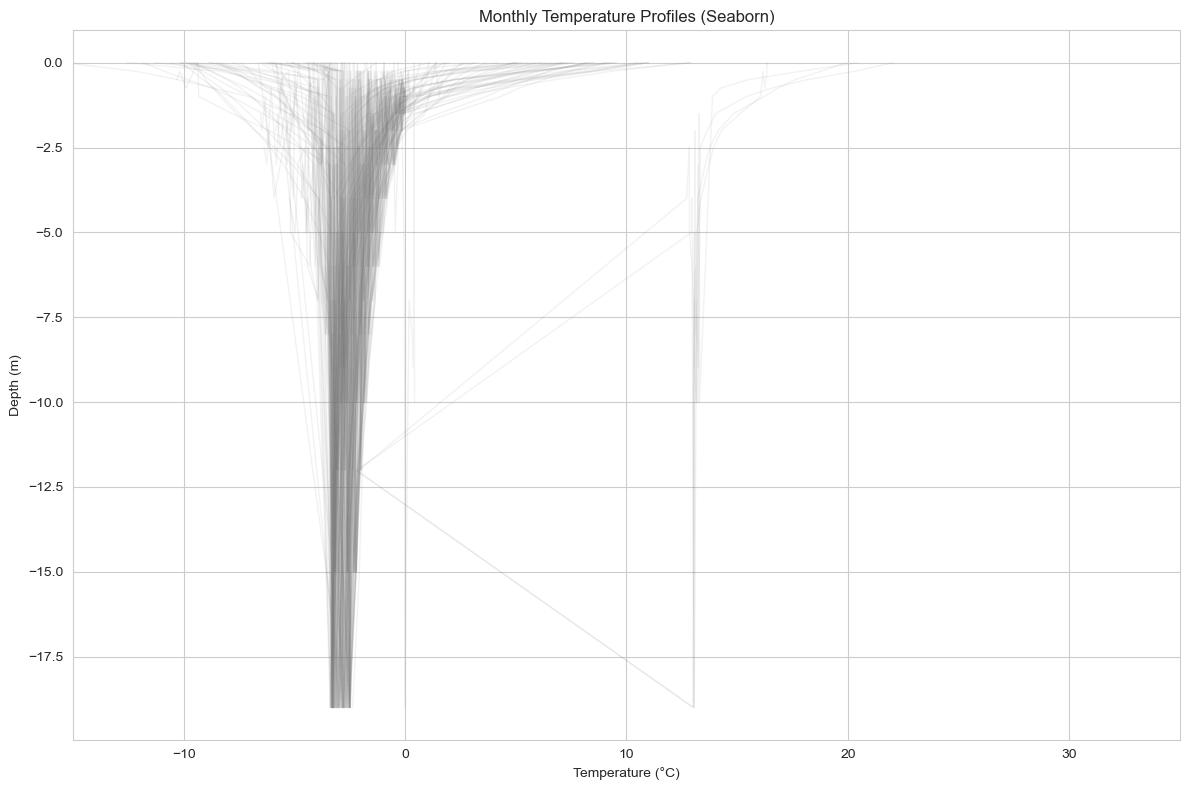


Zero-crossing depths (months where temperature crosses 0°C):
2008-09-30    1.037983
2009-06-30    0.252046
2009-07-31    0.834955
2009-08-31    1.125303
2009-09-30    1.071810
                ...   
2020-05-31    0.378622
2020-06-30    0.732034
2020-07-31    1.114208
2020-09-30    1.657009
2020-10-31    0.892411
Length: 66, dtype: float64


In [17]:
# Analyze first dataset
print("Analyzing first dataset...")
result = analyze_temperature_profile(dfs[0])
plt.show()

# Display zero-crossing depths
print("\nZero-crossing depths (months where temperature crosses 0°C):")
if len(result['zero_crossing_depths']) > 0:
    print(result['zero_crossing_depths'])
else:
    print("No zero-crossing depths found in this dataset")

In [13]:
# Assuming dfs is your list of dataframes and dfs[0] is the one to analyze
df_to_analyze = dfs[0].copy()

# If 'Date/Depth' is a column and not the index, set it as index
# to easily work with temperature columns.
# If it's already the index, this line is not strictly necessary but won't harm.
if 'Date/Depth' in df_to_analyze.columns:
    df_temp_data = df_to_analyze.set_index('Date/Depth')
else:
    df_temp_data = df_to_analyze

# Replace -999 with NaN in all temperature columns
df_temp_data = df_temp_data.replace(-999, np.nan)

# Calculate the maximum temperature across all depths and times
max_temp = df_temp_data.max().max()

# Calculate the minimum temperature across all depths and times
min_temp = df_temp_data.min().min()

print(f"Original DataFrame shape: {dfs[0].shape}")
print(f"DataFrame shape after setting index (if applicable): {df_temp_data.shape}")
print(f"Maximum temperature (excluding -999): {max_temp}°C")
print(f"Minimum temperature (excluding -999): {min_temp}°C")

# To see the min/max per depth column after replacing -999:
# print("\nMax temp per depth column:\n", df_temp_data.max())
# print("\nMin temp per depth column:\n", df_temp_data.min())

Original DataFrame shape: (17427, 20)
DataFrame shape after setting index (if applicable): (17427, 19)
Maximum temperature (excluding -999): 32.89°C
Minimum temperature (excluding -999): -23.96°C


In [11]:
dfs[0]

,Date/Depth,0,0.25,0.5,0.75,1,1.5,2,2.5,3,4,5,6,7,8,9,10,12,15,19
0,2008-09-16 12:00:00,4.900,3.770,2.340,0.970,0.100,-0.530,-0.980,-1.380,-1.710,-2.190,-2.540,-2.750,-2.900,-2.960,-3.030,-3.06,-3.140,-3.240,-3.390
1,2008-09-16 18:00:00,5.070,3.750,2.340,1.010,0.100,-0.540,-1.000,-1.380,-1.710,-2.190,-2.520,-2.750,-2.900,-2.960,-3.030,-3.06,-3.140,-3.240,-3.390
2,2008-09-17 00:00:00,4.780,3.740,2.360,1.030,0.100,-0.530,-0.990,-1.380,-1.710,-2.190,-2.520,-2.740,-2.890,-2.960,-3.030,-3.06,-3.140,-3.240,-3.390
3,2008-09-17 06:00:00,4.480,3.630,2.360,1.030,0.100,-0.530,-0.970,-1.370,-1.710,-2.190,-2.510,-2.740,-2.890,-2.960,-3.030,-3.06,-3.130,-3.230,-3.380
4,2008-09-17 12:00:00,4.450,3.530,2.330,1.030,0.120,-0.530,-0.970,-1.350,-1.710,-2.190,-2.510,-2.740,-2.890,-2.960,-3.030,-3.06,-3.130,-3.230,-3.380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17422,2020-10-16 12:00:00,-3.825,-2.109,-0.339,-0.077,-0.003,-0.041,-0.322,-0.812,-1.216,-2.089,-2.596,-2.910,-3.123,-3.189,-3.173,-3.06,-2.845,-2.553,-2.514
17423,2020-10-16 18:00:00,-4.325,-2.555,-0.395,-0.096,-0.003,-0.040,-0.322,-0.811,-1.216,-2.088,-2.596,-2.909,-3.123,-3.189,-3.173,-3.06,-2.844,-2.552,-2.534
17424,2020-10-17 00:00:00,-4.041,-2.250,-0.358,-0.077,-0.003,-0.040,-0.322,-0.811,-1.216,-2.088,-2.596,-2.909,-3.123,-3.189,-3.173,-3.06,-2.844,-2.552,-2.534
17425,2020-10-17 06:00:00,-6.481,-3.155,-0.471,-0.096,-0.003,-0.040,-0.322,-0.831,-1.196,-2.088,-2.596,-2.909,-3.123,-3.189,-3.173,-3.06,-2.844,-2.552,-2.534


In [19]:
import pandas as pd
import numpy as np
import plotly.express as px # Make sure plotly.express is imported

def create_animated_temperature_profile_plotly(df, df_name="Dataset"):
    """
    Create an animated monthly temperature profile using Plotly Express.

    Parameters:
    df (pd.DataFrame): Input DataFrame with 'Date/Depth' as the first column (or index)
                       and subsequent columns representing depths with temperature values.
                       -999 values are treated as NaN.
    df_name (str): Name of the dataset for the plot title.

    Returns:
    plotly.graph_objects.Figure: The animated Plotly figure, or None if data is insufficient.
    """
    
    # 1. Preprocessing
    if 'Date/Depth' in df.columns:
        df_indexed = df.set_index('Date/Depth')
    else:
        df_indexed = df.copy() # Use a copy if already indexed

    # Replace -999 with NaN before resampling and calculations
    df_indexed = df_indexed.replace(-999, np.nan)
    
    # 2. Calculate monthly averages
    # Ensure all actual temperature columns are numeric before resampling
    for col in df_indexed.columns:
        df_indexed[col] = pd.to_numeric(df_indexed[col], errors='coerce')
        
    monthly_avg = df_indexed.resample('ME').mean() # 'ME' for month end
    
    # Reset index to make month a column
    monthly_avg_reset = monthly_avg.reset_index()
    
    # Rename the date column for clarity
    monthly_avg_reset.rename(columns={'Date/Depth': 'Month_DateTime'}, inplace=True)
    
    # 3. Melt DataFrame to long format
    depth_columns_str = monthly_avg.columns.astype(str) # Original depth column names
    
    df_long = pd.melt(monthly_avg_reset, 
                      id_vars=['Month_DateTime'], 
                      value_vars=depth_columns_str, 
                      var_name='Depth_Str', # This will be like '0', '0.25'
                      value_name='Temperature')
    
    # 4. Convert data types and prepare for animation
    df_long['Depth'] = pd.to_numeric(df_long['Depth_Str'], errors='coerce')
    df_long['Temperature'] = pd.to_numeric(df_long['Temperature'], errors='coerce')
    
    # Convert Month_DateTime to string for animation frames (YYYY-MM)
    df_long['Month_Frame'] = df_long['Month_DateTime'].dt.strftime('%Y-%m')
    
    # Drop rows with NaN temperatures or depths as they can't be plotted
    df_long.dropna(subset=['Temperature', 'Depth'], inplace=True)
    
    # Sort values for correct line plotting within each frame
    df_long.sort_values(by=['Month_Frame', 'Depth'], inplace=True)

    if df_long.empty:
        print(f"No data available to plot for {df_name} after processing.")
        return None

    # Determine overall temperature and depth ranges for consistent axes
    min_temp_overall = df_long['Temperature'].min()
    max_temp_overall = df_long['Temperature'].max()
    temp_buffer = (max_temp_overall - min_temp_overall) * 0.05 if (max_temp_overall - min_temp_overall) > 0 else 1
    temp_range = [min_temp_overall - temp_buffer, max_temp_overall + temp_buffer]
    
    max_depth_overall = df_long['Depth'].max()
    depth_range_inverted = [- (max_depth_overall + (max_depth_overall*0.05 if max_depth_overall > 0 else 1)), 
                            (max_depth_overall*0.05 if max_depth_overall > 0 else 1)] # Depth range (inverted) + buffer

    # 5. Create animated plot
    fig = px.line(df_long,
                  x='Temperature',
                  y=df_long['Depth'] * -1, # Invert depth for y-axis display
                  animation_frame='Month_Frame',
                  labels={'Temperature': 'Temperature (°C)', 'y': 'Depth (m)'},
                  title=f'Animated Monthly Temperature Profiles: {df_name}',
                  range_x=temp_range,
                  range_y=depth_range_inverted 
                 )

    # Update layout for better animation control and appearance
    fig.update_layout(
        xaxis_title='Temperature (°C)',
        yaxis_title='Depth (m)',
    )
    # Ensure axes are not autoranged per frame
    fig.update_yaxes(autorange=False) 
    fig.update_xaxes(autorange=False)

    # Adjust animation speed (duration per frame and transition)
    if fig.layout.updatemenus and len(fig.layout.updatemenus) > 0 and \
       fig.layout.updatemenus[0].buttons and len(fig.layout.updatemenus[0].buttons) > 0:
        fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 300  # ms per frame
        fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 100 # ms for transition

    return fig


In [20]:
# Make sure dfs is loaded from your previous cells
# For example, using dfs[0] for the first dataset

# Extract a meaningful name for the title, e.g., from the filename if available
# This is a placeholder; you might have a better way to get dataset names
dataset_name_for_title = "Dataset 1" # Or extract from csv_files[0] in your load function

animated_fig = create_animated_temperature_profile_plotly(dfs[0], df_name=dataset_name_for_title)

if animated_fig:
    animated_fig.show() 
    # In some Jupyter environments, just having `animated_fig` as the last line also works.